In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline

In [3]:

def get_meteo_weather_history(lat, lon, start_date, end_date):

    # API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "America/Los_Angeles"
    }

    # Make the request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    weather_df = pd.DataFrame({
        "date": data["daily"]["time"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "temp_min": data["daily"]["temperature_2m_min"],
        "precipitation": data["daily"]["precipitation_sum"]
    })

    # Convert date to datetime object
    weather_df["date"] = pd.to_datetime(weather_df["date"])


    return weather_df


Get the weather for Fort Mason Equator Coffe (don't do this over and over - this uses a free open source api which asks its users to respect the usage)
Save it to a CSV
Turns out we only need to do Fort Mason as the other two coffee shops are close by

In [4]:
# Date range (based on your dataset)
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fort Mason - Equator Coffee lat lon
fortMasonLatitude = 37.805424841127625
fortMasonLongitude = -122.43189815767089
# only run this if we lose our data and need to pull it again (uses a free api)
if (False):
    weather_df = get_meteo_weather_history(fortMasonLatitude, fortMasonLongitude, start_date, end_date)
    # Save to CSV
    weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv", index=False)
else:
    #weather_df = pd.read_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv")
    weatherURL = "https://www.dropbox.com/scl/fi/khb765ddg0qox6iy8qtkb/sanfran_weather.csv?rlkey=yccip6qd8kcx0jqz80jocddqf&dl=1"
    weather_data = pd.read_csv(weatherURL)


# Preview
print(weather_data.head())


# # Lake Merrit - Equator Coffee lat lon  - DON'T BOTHER - LAT LON IS NEARLY THE SAME AS FORT MASON
# lakeMerritLatitude = 37.81242756270673
# lakeMerritongitude = -122.26105919815194
# weather_df = get_meteo_weather_history(lakeMerritLatitude, lakeMerritongitude, start_date, end_date)
# # Save to CSV
# weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\lake_merrit_open_meteo_weather.csv", index=False)


         date  temp_max  temp_min  precipitation
0  2019-01-01      12.1       4.2            0.0
1  2019-01-02      11.6       4.5            0.0
2  2019-01-03      10.9       4.6            0.0
3  2019-01-04      12.0       4.9            0.0
4  2019-01-05      12.7       9.4            5.8


Clean the Data - Remove specific days like Christmas, New Years, etc.

In [5]:
# List of holidays to remove
holidays = [
    '2019-01-01', '2019-12-25', '2020-01-01', '2020-12-25', 
    '2021-01-01', '2021-12-25', '2022-01-01', '2022-12-25', 
    '2023-01-01', '2023-12-25', '2024-01-01', '2024-12-25'
]
# Convert holidays to datetime
holidays = pd.to_datetime(holidays)

# Remove holidays from weather data
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data[~weather_data['date'].isin(holidays)]

print("\nCleaned Weather Data:")
print(weather_data.head())


Cleaned Weather Data:
        date  temp_max  temp_min  precipitation
1 2019-01-02      11.6       4.5            0.0
2 2019-01-03      10.9       4.6            0.0
3 2019-01-04      12.0       4.9            0.0
4 2019-01-05      12.7       9.4            5.8
5 2019-01-06      13.4       8.5           36.5


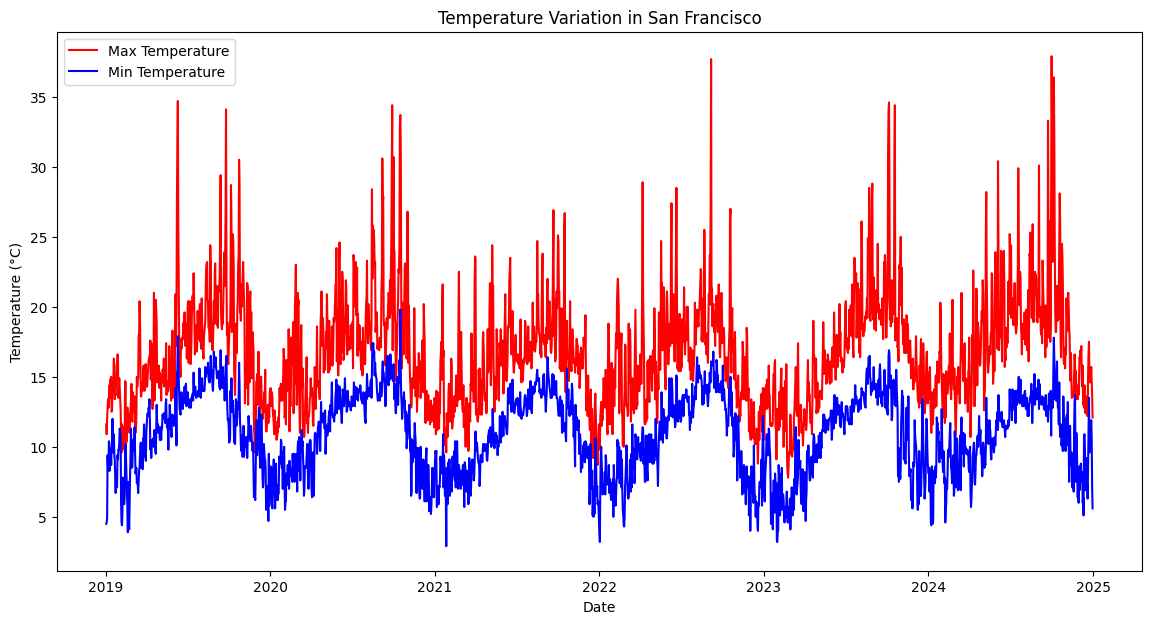

In [6]:
# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()
plt.show()


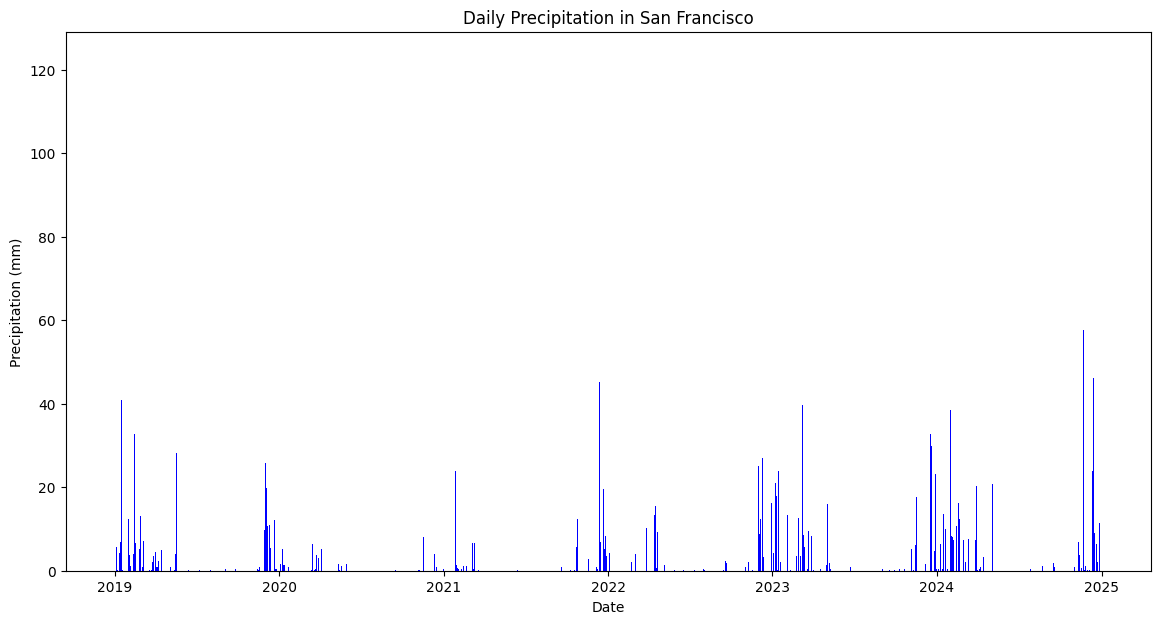

In [7]:
plt.figure(figsize=(14, 7))
plt.bar(weather_data['date'], weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco')
plt.show()

In [8]:
# Find the day with the highest precipitation
max_precipitation_day = weather_data.loc[weather_data['precipitation'].idxmax()]

print("Day with the highest precipitation:")
print(max_precipitation_day)

# How many days have precipitation greater than 50mm?
high_precipitation_days = weather_data[weather_data['precipitation'] > 50]
print("\nNumber of days with precipitation greater than 50mm:")
print(len(high_precipitation_days))


Day with the highest precipitation:
date             2022-12-31 00:00:00
temp_max                        13.2
temp_min                        10.5
precipitation                  123.0
Name: 1460, dtype: object

Number of days with precipitation greater than 50mm:
4


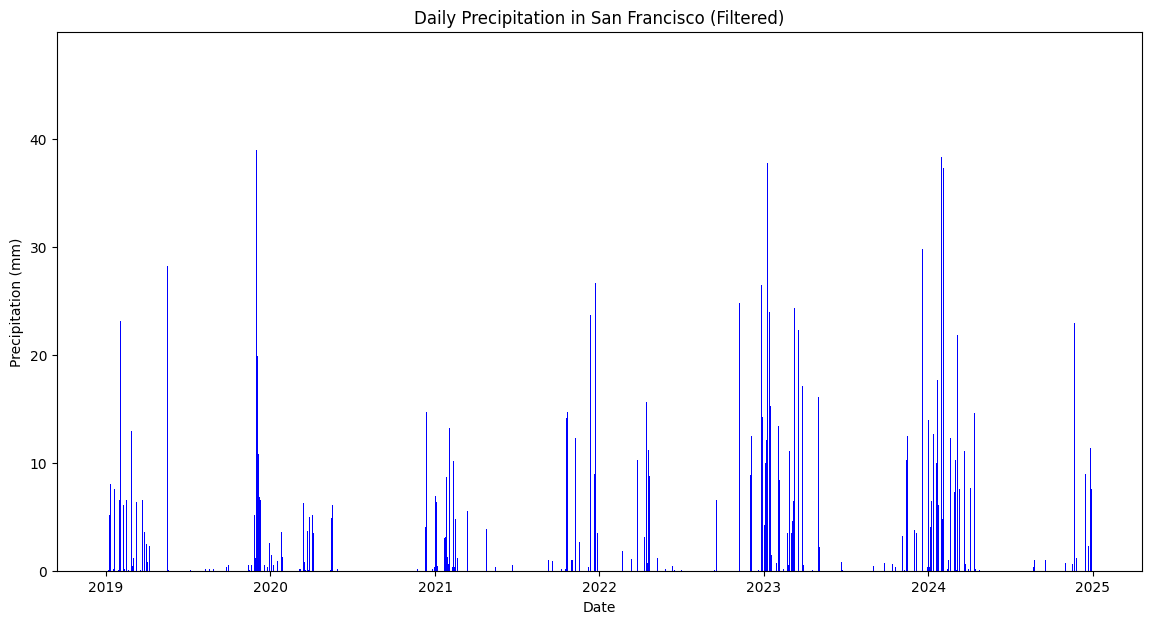

In [9]:
# Filter out days with precipitation greater than 50mm
filtered_weather_data = weather_data[weather_data['precipitation'] <= 50]

# Plot the daily precipitation
plt.figure(figsize=(14, 7))
plt.bar(filtered_weather_data['date'], filtered_weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco (Filtered)')
plt.show()

Next let's get our sales data for the 3 stores

Start with Fort Mason

In [10]:
fortMason5ySalesURL = "https://www.dropbox.com/scl/fi/c73v6ce9ij7rupc74quyz/FortMason5yrNetSalesbyDay.csv?rlkey=lnt0t56erqvea18fh052komur&dl=1"
fortMason5y_data = pd.read_csv(fortMason5ySalesURL)

# Preview
print(fortMason5y_data.head())



   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
1            6    Fort Mason  1/1/2019     Tuesday             FOOD   
2            6    Fort Mason  1/1/2019     Tuesday             FOOD   
3            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
4            6    Fort Mason  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1908.65        17.75             0  
1      Baked Goods-Pantry   199.75         0.00             0  
2  Retail Packaged-Pantry   178.00         0.00             0  
3         Other Beverages   163.50         0.00             0  
4           Retail Coffee   119.50         0.00             0  


Clean the Data

In [11]:
# Remove System Balance from the data
fortMason5y_data = fortMason5y_data[fortMason5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
fortMason5y_data = fortMason5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the fortMason5y_data
fortMason5y_data['DOB'] = pd.to_datetime(fortMason5y_data['DOB'])
fortMason5y_data = fortMason5y_data[~fortMason5y_data['DOB'].isin(holidays)]

# Preview
print(fortMason5y_data.head())


    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
12            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
13            6    Fort Mason 2019-01-02   Wednesday             FOOD   
14            6    Fort Mason 2019-01-02   Wednesday             FOOD   
15            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
16            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                           SD   AMOUNT  COMP AMOUNT  
12       Retail Coffee Drinks  1191.81        10.59  
13         Baked Goods-Pantry   209.00         0.00  
14  Retail Packaged-3rd party   196.26         2.24  
15                Accessories   196.00         5.00  
16              Retail Coffee   158.00         0.00  


More cleaning - Making an assumption that the store is closed if it has 0 regular coffee sales

In [12]:
# Print total entries
print("\nTotal entries:", len(fortMason5y_data))

# Append the dates where there are less than 4 DOB entries (i.e. less than 4 sales on that day) to the holidays
#holidays = holidays.append(pd.to_datetime(fortMason5y_data.groupby('DOB').filter(lambda x: len(x) < 4)['DOB'].unique()))


# store all the dates where there are less than 4 DOB entries (i.e. less than 4 sales on that day)
combinedDatesToRemove = pd.to_datetime(fortMason5y_data.groupby('DOB').filter(lambda x: len(x) < 4)['DOB'].unique())
print("Combined Dates to Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Remove entries where there are less than 4 DOB entries (i.e. less than 4 sales on that day) 
fortMason5y_data = fortMason5y_data.groupby('DOB').filter(lambda x: len(x) > 3) 

# Print total entries
print("\nTotal entries:", len(fortMason5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
fortMason5y_coffee_data = fortMason5y_data[fortMason5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(fortMason5y_coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = fortMason5y_coffee_data[fortMason5y_coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))



Total entries: 19791
Combined Dates to Remove: 5
<DatetimeArray>
['2020-03-25 00:00:00', '2020-04-08 00:00:00', '2023-07-31 00:00:00',
 '2023-08-01 00:00:00', '2023-08-02 00:00:00']
Length: 5, dtype: datetime64[ns]

Total entries: 19782
     LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
12             6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
24             6    Fort Mason 2019-01-03    Thursday  COFFEE & NA BEV   
36             6    Fort Mason 2019-01-04      Friday  COFFEE & NA BEV   
47             6    Fort Mason 2019-01-05    Saturday  COFFEE & NA BEV   
58             6    Fort Mason 2019-01-06      Sunday  COFFEE & NA BEV   
70             6    Fort Mason 2019-01-07      Monday  COFFEE & NA BEV   
83             6    Fort Mason 2019-01-08     Tuesday  COFFEE & NA BEV   
95             6    Fort Mason 2019-01-09   Wednesday  COFFEE & NA BEV   
104            6    Fort Mason 2019-01-10    Thursday  COFFEE & NA BEV   
116            6    Fo

SD
Accessories               123975.46
BLANK NAME                  4702.66
Baked Goods-3rd party    1166455.65
Baked Goods-Pantry         89699.68
Beer & Wine                23508.07
Brewing Equipment           4297.32
Catering                   35237.85
Donation                      30.00
Extra Items                   58.95
Ice Cream                   4348.45
Name: AMOUNT, dtype: float64
SD
Accessories                  1.239755e+05
BLANK NAME                   4.702660e+03
Baked Goods-3rd party        1.166456e+06
Baked Goods-Pantry           8.969968e+04
Beer & Wine                  2.350807e+04
Brewing Equipment            4.297320e+03
Catering                     3.523785e+04
Donation                     3.000000e+01
Extra Items                  5.895000e+01
Ice Cream                    4.348450e+03
Other Beverages              1.935497e+05
Prepared Foods               6.161124e+05
Retail Coffee                5.981950e+05
Retail Coffee Drinks         5.054548e+06
Retail Packaged-3

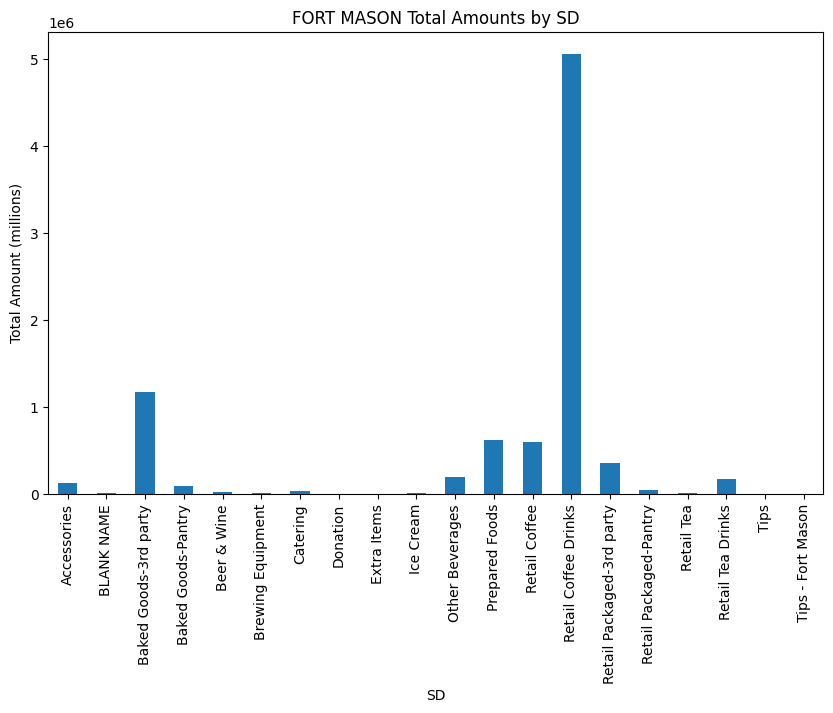

In [13]:

# Group the data by 'SD' and sum the 'AMOUNT'
fm_grouped_data = fortMason5y_data.groupby('SD')['AMOUNT'].sum()
print(fm_grouped_data.head(10))
print(fm_grouped_data)

# # Remove System Balance from the data
# fm_grouped_data = fm_grouped_data.drop('System Balance')

# Plot the data
plt.figure(figsize=(10, 6))
fm_grouped_data.plot(kind='bar')
plt.title('FORT MASON Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount (millions)')
plt.show()

In [14]:
blank_name_indices = fortMason5y_data[fortMason5y_data['SD'] == 'BLANK NAME'].index
print(blank_name_indices)

Index([ 4895,  4907,  4920,  4935,  4945,  4958,  4970,  4982,  4993,  5007,
        5030,  5038,  5052,  5390,  5398,  5405,  5410,  5435,  5440,  5448,
        5456,  5471,  5481,  5492,  5500,  5508,  5514,  6226,  6236,  6247,
        6254,  6264,  6553,  6631,  6669,  6680, 13514, 13721, 13911, 14025,
       14065, 14171, 15003, 15012, 15022, 15031, 15048, 15073, 15082, 15107,
       15117, 15128, 15496, 16007],
      dtype='int64')


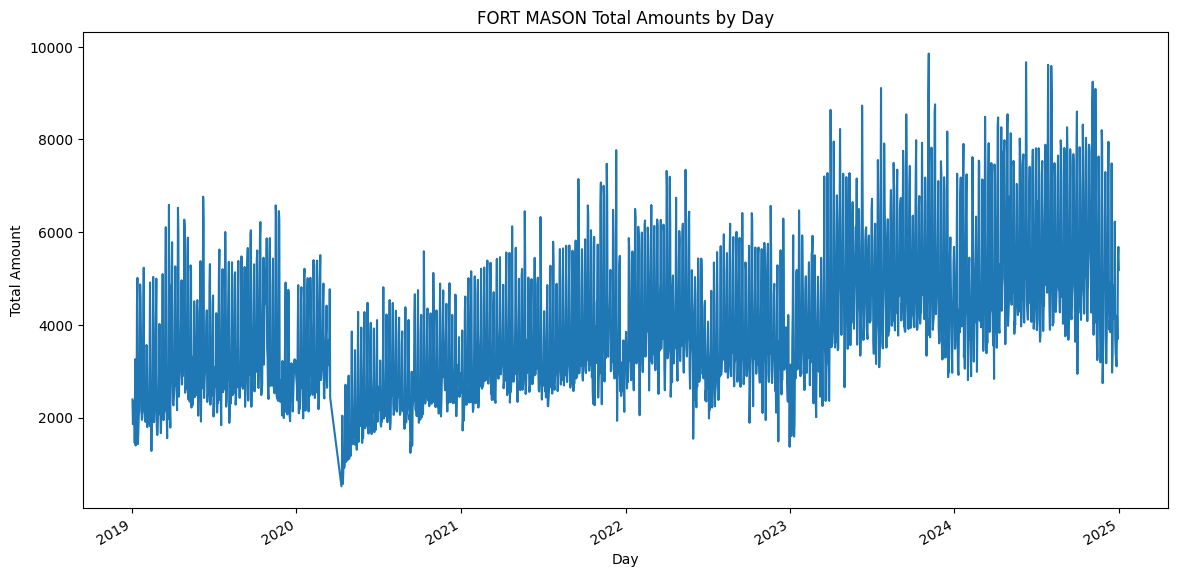

In [15]:
# Group the data by 'DOB' and sum the 'AMOUNT'
fm_daily_totals = fortMason5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
fm_daily_totals.plot(kind='line')
plt.title('FORT MASON Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()

In [16]:
# Find the days with zero sales (or very low sales) - see if they are Christmas, New Year's Day, etc. - but maybe it's too much rain or too hot!?
sales_anomolies_max = 250

unusually_low_sales_days = fm_daily_totals[fm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)


Now do Lake Merritt

In [17]:
lakeMerritt5ySalesURL = "https://www.dropbox.com/scl/fi/zcfrcc3mlhuapy2bqbyhc/LakeMerritt5yrNetSalesbyDay.csv?rlkey=7b0vk7k3frcwkoxg281tx4mpu&dl=1"
lakeMerritt5y_data = pd.read_csv(lakeMerritt5ySalesURL)

# Preview
print(lakeMerritt5y_data.head())


   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            7  Lake Merritt  1/1/2019     Tuesday  COFFEE & NA BEV   
1            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
2            7  Lake Merritt  1/1/2019     Tuesday           RETAIL   
3            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
4            7  Lake Merritt  1/1/2019     Tuesday             FOOD   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1141.88         0.22             0  
1      Baked Goods-Pantry   125.50         0.00             0  
2           Retail Coffee   108.00         0.00             0  
3          Prepared Foods    72.00         0.00             0  
4  Retail Packaged-Pantry    51.50         0.00             0  


Clean the data

In [18]:
# Remove System Balance from the data
lakeMerritt5y_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
lakeMerritt5y_data = lakeMerritt5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the data
lakeMerritt5y_data['DOB'] = pd.to_datetime(lakeMerritt5y_data['DOB'])
lakeMerritt5y_data = lakeMerritt5y_data[~lakeMerritt5y_data['DOB'].isin(holidays)]

# Preview
print(lakeMerritt5y_data.head())

    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
9             7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   
10            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
11            7  Lake Merritt 2019-01-02   Wednesday           RETAIL   
12            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
13            7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   

                        SD  AMOUNT  COMP AMOUNT  
9     Retail Coffee Drinks  602.68         2.52  
10      Baked Goods-Pantry  104.50         0.00  
11           Retail Coffee   47.45         0.00  
12  Retail Packaged-Pantry   44.00         0.00  
13       Retail Tea Drinks   21.00         0.00  


More cleaning - get rid of days with what appears to be only private sales

In [19]:
# Print total entries
print("\nTotal entries:", len(lakeMerritt5y_data))

# store all the dates where there are less than 4 DOB entries (i.e. less than 4 sales on that day)
datesToRemove = pd.to_datetime(lakeMerritt5y_data.groupby('DOB').filter(lambda x: len(x) < 4)['DOB'].unique())
print(datesToRemove)

# add the dates to the combinedDatesToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, datesToRemove])
print("Combined Dates To Remove entries:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Remove entries where there are less than 4 DOB entries (i.e. less than 4 sales on that day)
lakeMerritt5y_data = lakeMerritt5y_data.groupby('DOB').filter(lambda x: len(x) > 3)
# Print total entries
print("\nTotal entries:", len(lakeMerritt5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
coffee_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = coffee_data[coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))


Total entries: 16524
<DatetimeArray>
['2020-03-17 00:00:00', '2020-03-20 00:00:00', '2020-04-02 00:00:00',
 '2023-12-13 00:00:00']
Length: 4, dtype: datetime64[ns]
Combined Dates To Remove entries: 9
['2020-03-25T00:00:00.000000000' '2020-04-08T00:00:00.000000000'
 '2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2020-03-17T00:00:00.000000000'
 '2020-03-20T00:00:00.000000000' '2020-04-02T00:00:00.000000000'
 '2023-12-13T00:00:00.000000000']

Total entries: 16518
    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
9             7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   
18            7  Lake Merritt 2019-01-03    Thursday  COFFEE & NA BEV   
26            7  Lake Merritt 2019-01-04      Friday  COFFEE & NA BEV   
36            7  Lake Merritt 2019-01-05    Saturday  COFFEE & NA BEV   
45            7  Lake Merritt 2019-01-06      Sunday  COFFEE & NA BEV   
51            7  Lake Merritt 2019-01-07     

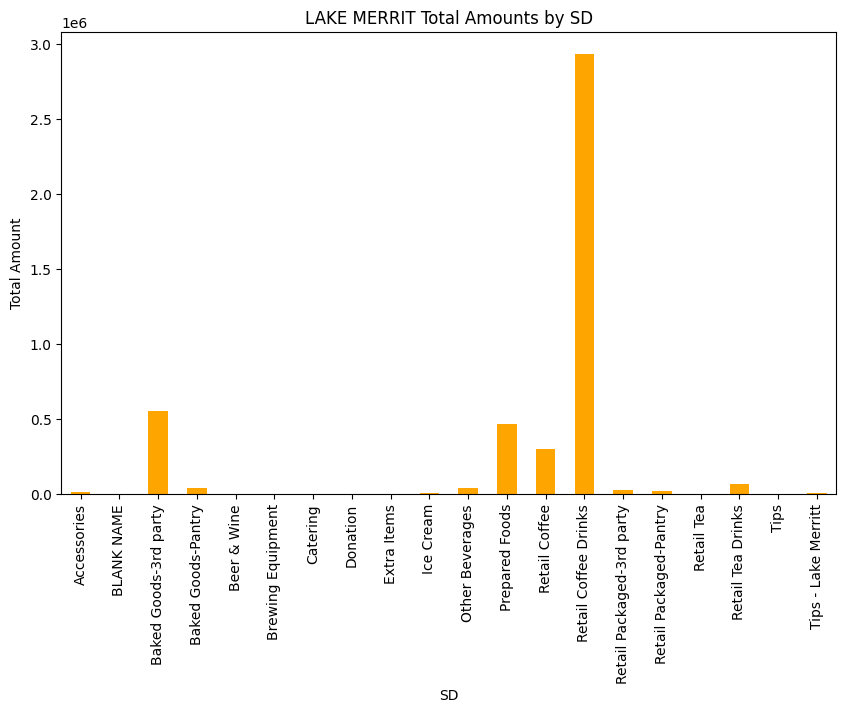

In [20]:
# Group the data by 'SD' and sum the 'AMOUNT'
lm_grouped_data = lakeMerritt5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
lm_grouped_data.plot(kind='bar', color='orange')
plt.title('LAKE MERRIT Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

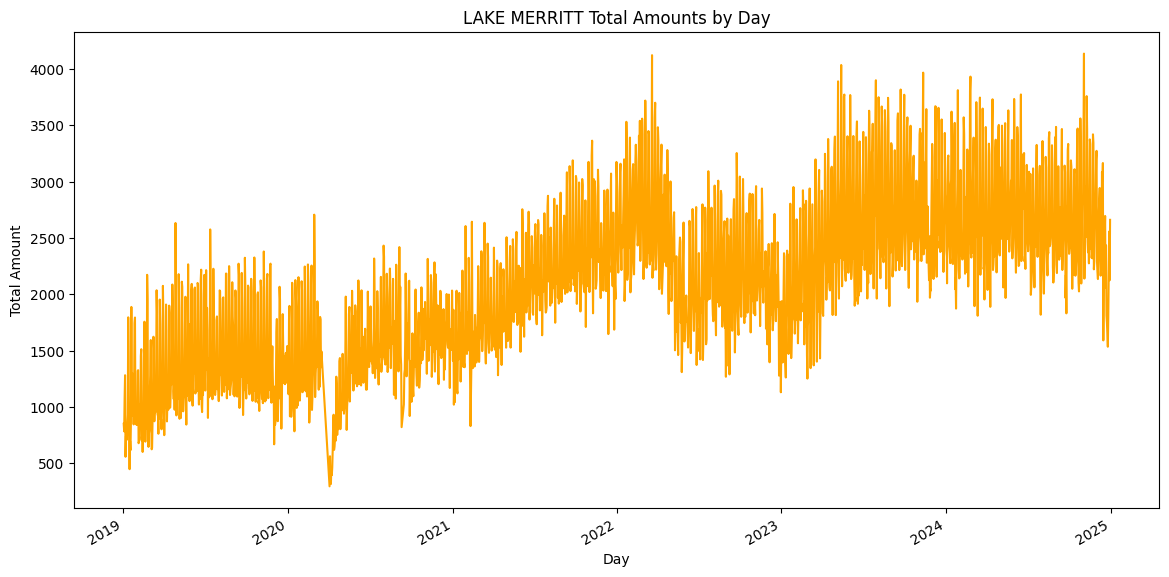

In [21]:
# Group the data by 'DOB' and sum the 'AMOUNT'
lm_daily_totals = lakeMerritt5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
lm_daily_totals.plot(kind='line', color='orange')
plt.title('LAKE MERRITT Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [22]:
unusually_low_sales_days = lm_daily_totals[lm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)


Finally, do Larkspur

In [23]:
larkspur5ySalesURL = "https://www.dropbox.com/scl/fi/n037thzcegug919e0ajqj/Larkspur5yrNetSalesbyDay.csv?rlkey=3pg7sv4fbur1tfo2ax7ebz70z&dl=1"
larkspur5y_data = pd.read_csv(larkspur5ySalesURL)

# Preview
print(larkspur5y_data.head())

   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            4      Larkspur  1/1/2019     Tuesday  COFFEE & NA BEV   
1            4      Larkspur  1/1/2019     Tuesday             FOOD   
2            4      Larkspur  1/1/2019     Tuesday             FOOD   
3            4      Larkspur  1/1/2019     Tuesday             FOOD   
4            4      Larkspur  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1612.96        35.14             0  
1      Baked Goods-Pantry   185.00         0.00             0  
2   Baked Goods-3rd party   175.00         0.00             0  
3  Retail Packaged-Pantry   144.75         0.00             0  
4           Retail Coffee   142.50         0.00             0  


Clean the data

In [24]:
# Remove System Balance from the data
larkspur5y_data = larkspur5y_data[larkspur5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
larkspur5y_data = larkspur5y_data.drop(columns=['PROMO AMOUNT'])

# Remove the holidays from the data
larkspur5y_data['DOB'] = pd.to_datetime(larkspur5y_data['DOB'])
larkspur5y_data = larkspur5y_data[~larkspur5y_data['DOB'].isin(holidays)]


# these days should be removed for anomalies like power outages, etc.
daysToRemove = [
    '2021-10-24', '2024-12-14',
    '2024-02-07', '2024-11-20', '2024-12-15',
    '2023-01-10', '2023-11-28'

]
larkspur5y_data = larkspur5y_data[~larkspur5y_data['DOB'].isin(daysToRemove)]

daysToRemove = pd.to_datetime(daysToRemove)

# add the dates to the combinedDatesToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, daysToRemove])
print("\nCombined Dates To Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Preview
print(larkspur5y_data.head())


Combined Dates To Remove: 16
['2020-03-25T00:00:00.000000000' '2020-04-08T00:00:00.000000000'
 '2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2020-03-17T00:00:00.000000000'
 '2020-03-20T00:00:00.000000000' '2020-04-02T00:00:00.000000000'
 '2023-12-13T00:00:00.000000000' '2021-10-24T00:00:00.000000000'
 '2024-12-14T00:00:00.000000000' '2024-02-07T00:00:00.000000000'
 '2024-11-20T00:00:00.000000000' '2024-12-15T00:00:00.000000000'
 '2023-01-10T00:00:00.000000000' '2023-11-28T00:00:00.000000000']
    LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
14            4      Larkspur 2019-01-02   Wednesday  COFFEE & NA BEV   
15            4      Larkspur 2019-01-02   Wednesday             FOOD   
16            4      Larkspur 2019-01-02   Wednesday             FOOD   
17            4      Larkspur 2019-01-02   Wednesday           RETAIL   
18            4      Larkspur 2019-01-02   Wednesday             FOOD   

          

C:\Users\Paul\AppData\Local\Temp\ipykernel_16324\570442289.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  larkspur5y_data = larkspur5y_data[~larkspur5y_data['DOB'].isin(daysToRemove)]


More cleaning - get rid of the days with appear to be private sales only

In [25]:
# Print total entries
print("\nTotal entries:", len(larkspur5y_data))

# store all the dates where there are less than 4 DOB entries (i.e. less than 4 sales on that day)
datesToRemove = pd.to_datetime(larkspur5y_data.groupby('DOB').filter(lambda x: len(x) < 4)['DOB'].unique())
print(datesToRemove)
# add the dates to the daysToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, datesToRemove])
print("\nCombined Dates To Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)


# Remove entries where there are less than 4 DOB entries (i.e. less than 4 sales on that day)
larkspur5y_data = larkspur5y_data.groupby('DOB').filter(lambda x: len(x) > 3)
# Print total entries
print("\nTotal entries:", len(larkspur5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
coffee_data = larkspur5y_data[larkspur5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = coffee_data[coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))


Total entries: 18821
<DatetimeArray>
['2020-03-17 00:00:00', '2020-04-04 00:00:00', '2020-04-15 00:00:00',
 '2023-11-27 00:00:00', '2024-02-05 00:00:00']
Length: 5, dtype: datetime64[ns]

Combined Dates To Remove: 21
['2020-03-25T00:00:00.000000000' '2020-04-08T00:00:00.000000000'
 '2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2020-03-17T00:00:00.000000000'
 '2020-03-20T00:00:00.000000000' '2020-04-02T00:00:00.000000000'
 '2023-12-13T00:00:00.000000000' '2021-10-24T00:00:00.000000000'
 '2024-12-14T00:00:00.000000000' '2024-02-07T00:00:00.000000000'
 '2024-11-20T00:00:00.000000000' '2024-12-15T00:00:00.000000000'
 '2023-01-10T00:00:00.000000000' '2023-11-28T00:00:00.000000000'
 '2020-03-17T00:00:00.000000000' '2020-04-04T00:00:00.000000000'
 '2020-04-15T00:00:00.000000000' '2023-11-27T00:00:00.000000000'
 '2024-02-05T00:00:00.000000000']

Total entries: 18814
     LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
14

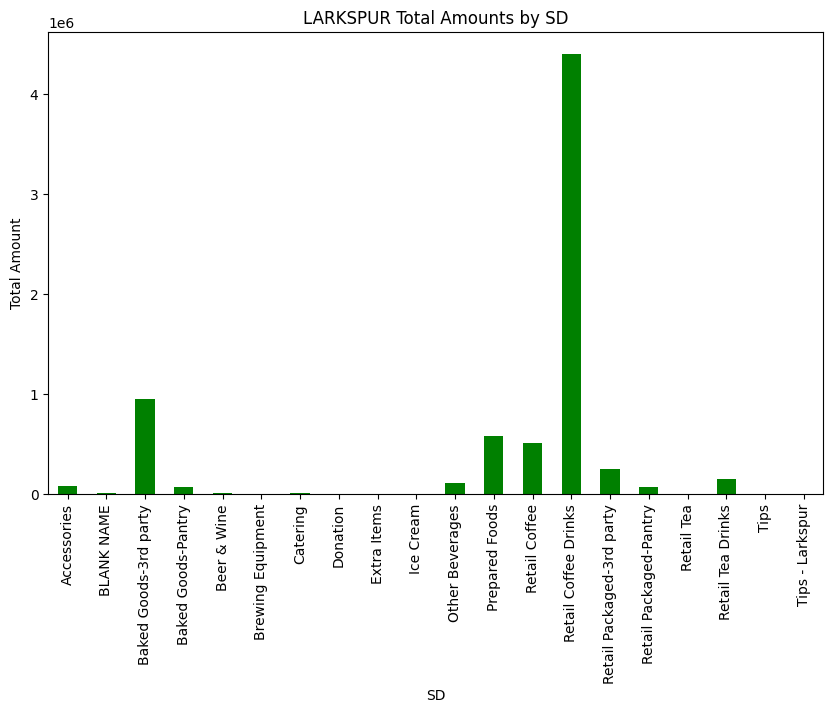

In [26]:
# Group the data by 'SD' and sum the 'AMOUNT'
ls_grouped_data = larkspur5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
ls_grouped_data.plot(kind='bar', color='green')
plt.title('LARKSPUR Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

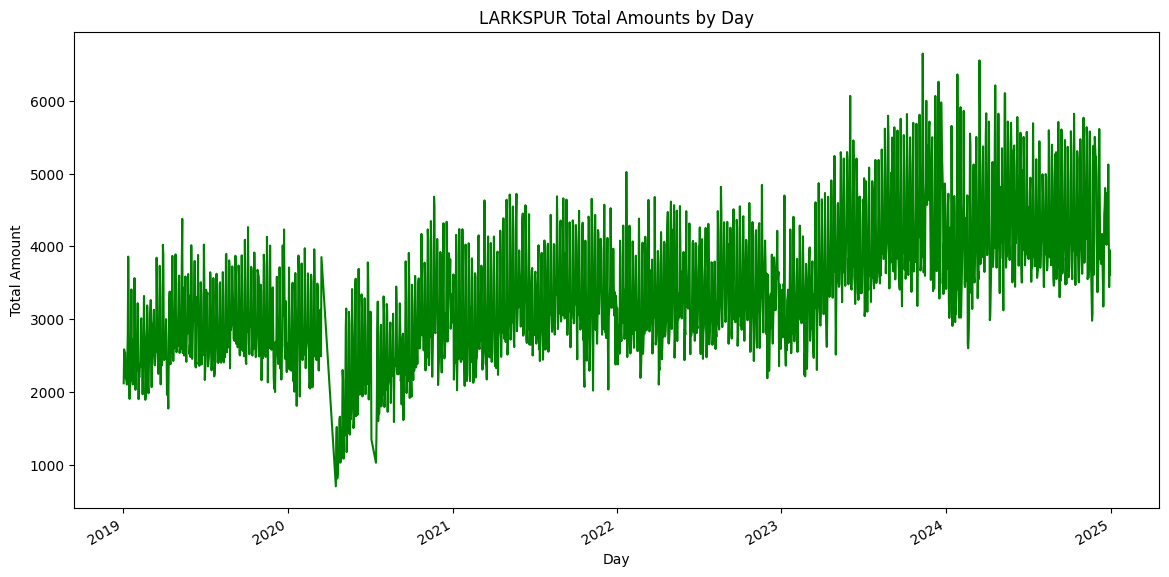

In [27]:
# # Convert 'DOB' to datetime
# larkspur5y_data['DOB'] = pd.to_datetime(larkspur5y_data['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
ls_daily_totals = larkspur5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
ls_daily_totals.plot(kind='line', color='green')
plt.title('LARKSPUR Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [28]:
unusually_low_sales_days = ls_daily_totals[ls_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

low_sales_days = ls_daily_totals[ls_daily_totals < 2500]
print('low_sales_days')
print(low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)
low_sales_days
DOB
2019-01-02    2119.01
2019-01-04    2442.86
2019-01-06    2250.35
2019-01-07    2181.96
2019-01-08    2169.26
               ...   
2023-02-21    2233.50
2023-02-23    2215.00
2023-02-27    2317.93
2023-03-14    2468.40
2023-03-21    2302.38
Name: AMOUNT, Length: 321, dtype: float64


Merge the sales date for all 3 stores into one graph

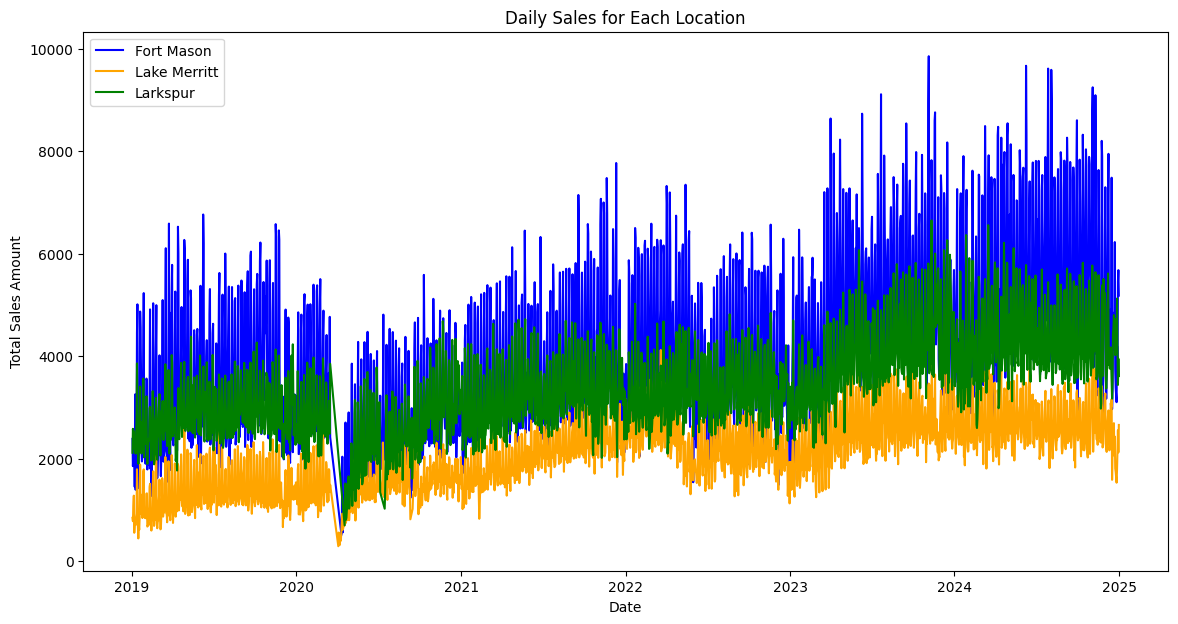

In [29]:
# Plot the daily sales for each location in one graph
plt.figure(figsize=(14, 7))

# Plot Fort Mason daily sales
plt.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason', color='blue')

# Plot Lake Merritt daily sales
plt.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt', color='orange')

# Plot Larkspur daily sales
plt.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Daily Sales for Each Location')
plt.legend()

# Show the plot
plt.show()

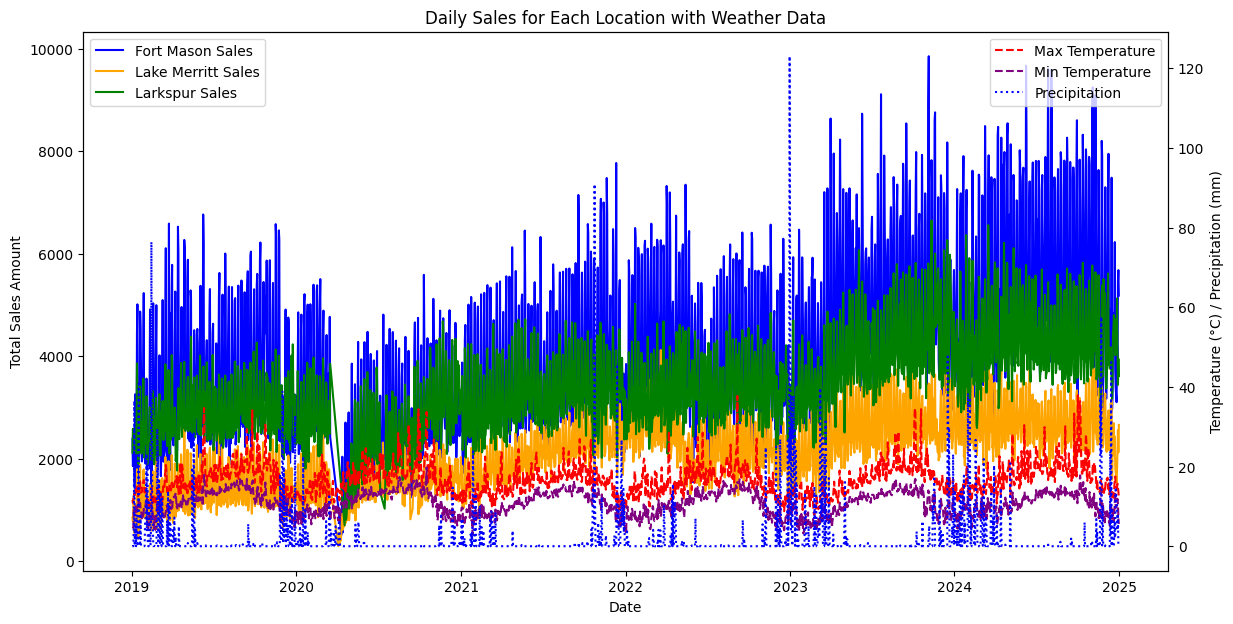

In [30]:
# Plot the daily sales for each location in one graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Fort Mason daily sales
ax1.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason Sales', color='blue')

# Plot Lake Merritt daily sales
ax1.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt Sales', color='orange')

# Plot Larkspur daily sales
ax1.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur Sales', color='green')

# Add labels and title for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount')
ax1.set_title('Daily Sales for Each Location with Weather Data')
ax1.legend(loc='upper left')

# Create a secondary y-axis for weather data
ax2 = ax1.twinx()

# Plot Max Temperature
ax2.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red', linestyle='--')

# Plot Min Temperature
ax2.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='purple', linestyle='--')

# Plot Precipitation
ax2.plot(weather_data['date'], weather_data['precipitation'], label='Precipitation', color='blue', linestyle=':')

# Add labels for weather data
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [31]:
# Combine the sales data from all three locations
combined_sales_data = pd.concat([fortMason5y_data, lakeMerritt5y_data, larkspur5y_data])

# Reset the index
combined_sales_data.reset_index(drop=True, inplace=True)

print("Combined Sales Data Length:", len(combined_sales_data))

# Remove the combined dates to remove fomr the combined sales data
combined_sales_data['DOB'] = pd.to_datetime(combined_sales_data['DOB'])
combined_sales_data = combined_sales_data[~combined_sales_data['DOB'].isin(combinedDatesToRemove)]
print("Combined Sales Data Lengt After Dates Cleaned!:", len(combined_sales_data))

# Check for sales data for ALL 3 STORES
# Remove entries where there are less than 12 DOB entries (i.e. less than 4 sales on that day for each store)
combined_sales_data = combined_sales_data.groupby('DOB').filter(lambda x: len(x) > 11)
# Print total entries
print("\nTotal entries:", len(combined_sales_data))


# Preview the combined data
print(combined_sales_data.head())
print(combined_sales_data.tail())

Combined Sales Data Length: 55114
Combined Sales Data Lengt After Dates Cleaned!: 54889

Total entries: 54840
   LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
0            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
1            6    Fort Mason 2019-01-02   Wednesday             FOOD   
2            6    Fort Mason 2019-01-02   Wednesday             FOOD   
3            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
4            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                          SD   AMOUNT  COMP AMOUNT  
0       Retail Coffee Drinks  1191.81        10.59  
1         Baked Goods-Pantry   209.00         0.00  
2  Retail Packaged-3rd party   196.26         2.24  
3                Accessories   196.00         5.00  
4              Retail Coffee   158.00         0.00  
       LOCATION ID LOCATION NAME        DOB DAY OF WEEK              MSD  \
55109            4      Larkspur 2024-12-31     Tuesday        

SD
Accessories               211616.37
BLANK NAME                 10786.52
Baked Goods-3rd party    2655872.74
Baked Goods-Pantry        199733.28
Beer & Wine                38240.69
Brewing Equipment           9429.69
Catering                   43656.74
Donation                      51.92
Extra Items                  122.20
Ice Cream                   9547.95
Name: AMOUNT, dtype: float64
SD
Retail Coffee                1.404065e+06
Retail Coffee Drinks         1.233784e+07
Retail Packaged-3rd party    6.301567e+05
Retail Packaged-Pantry       1.342055e+05
Retail Tea                   1.383735e+04
Retail Tea Drinks            3.778168e+05
Tips                         3.640000e+02
Tips - Fort Mason            3.665630e+03
Tips - Lake Merritt          3.182020e+03
Tips - Larkspur              3.434180e+03
Name: AMOUNT, dtype: float64


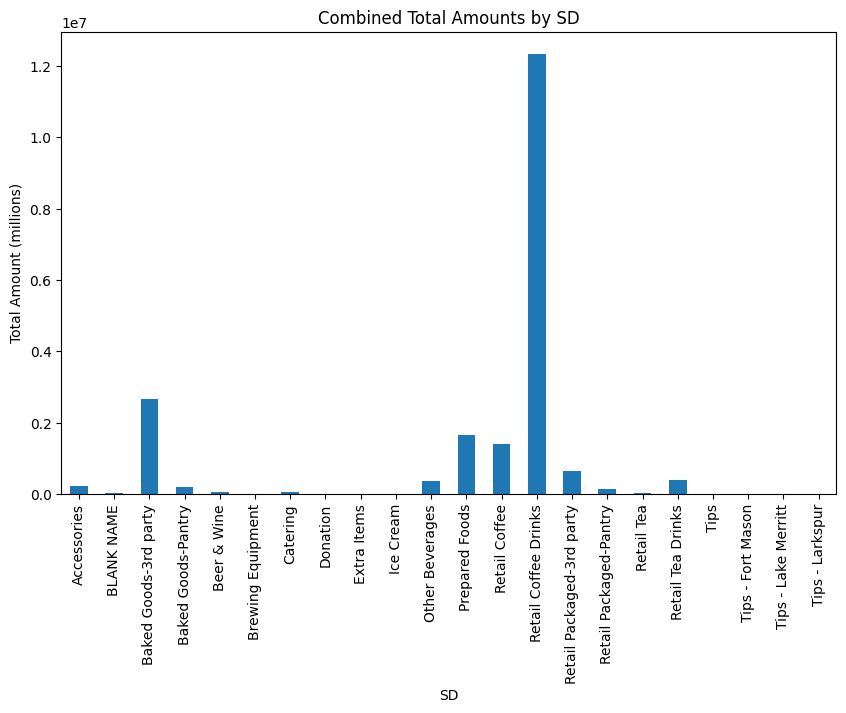

In [32]:
# Group the data by 'SD' and sum the 'AMOUNT'
combined_grouped_data = combined_sales_data.groupby('SD')['AMOUNT'].sum()
print(combined_grouped_data.head(10))
print(combined_grouped_data.tail(10))   

# # Remove System Balance from the data
# fm_grouped_data = fm_grouped_data.drop('System Balance')

# Plot the data
plt.figure(figsize=(10, 6))
combined_grouped_data.plot(kind='bar')
plt.title('Combined Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount (millions)')
plt.show()

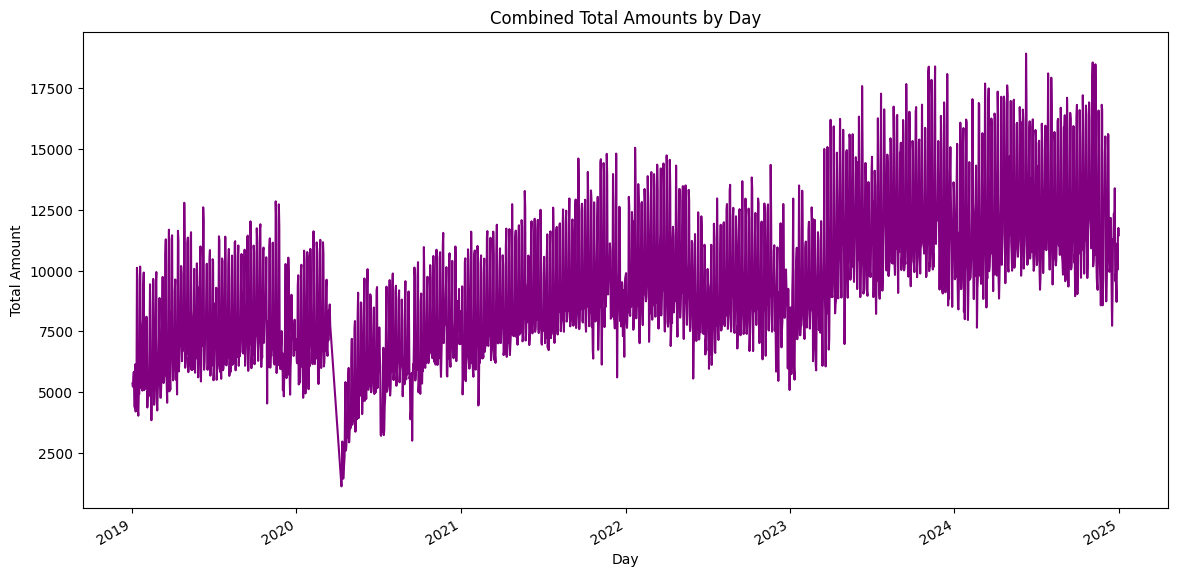

In [33]:
# Group the data by 'DOB' and sum the 'AMOUNT'
combined_daily_totals = combined_sales_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
combined_daily_totals.plot(kind='line', color='purple')
plt.title('Combined Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [34]:
# one last time to check anomalies
unusually_low_sales_days = combined_daily_totals[combined_daily_totals < 6000]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2019-01-02    5359.4600
2019-01-03    5226.5299
2019-01-04    5615.5300
2019-01-05    5836.6798
2019-01-06    5163.5300
                ...    
2022-12-27    5978.0500
2022-12-31    5093.6400
2023-01-04    5747.2500
2023-01-11    5516.7400
2023-02-28    5899.6100
Name: AMOUNT, Length: 246, dtype: float64


Finally, remove the combined dates to remove from the weather data so that every date with weather matches a date with legitimate sales data

In [37]:
# Remove combined dates to remove from weather data
print("Weather Data Length before matching:", len(weather_data))
print("Combined Dates to Reomve Length:", len(combinedDatesToRemove))
combined_weather_data = weather_data[~weather_data['date'].isin(combinedDatesToRemove)]
print("Combined Weather Data Length:", len(combined_weather_data))
print("Combined Sales Data Length:", len(combined_daily_totals))


# Remove all dates from the combined weather data that are not in the combined sales data
combined_weather_data = combined_weather_data[combined_weather_data['date'].isin(combined_daily_totals.index)]
print("Combined Weather Data Length:", len(combined_weather_data))
print("Combined Sales Data Length:", len(combined_daily_totals))


Weather Data Length before matching: 2180
Combined Dates to Reomve Length: 21
Combined Weather Data Length: 2160
Combined Sales Data Length: 2135
Combined Weather Data Length: 2135
Combined Sales Data Length: 2135


TODO - TEAM - USE THESE 3 VALUES FOR YOUR MODELS!!!!

1. combined_sales_data = All 3 stores combined with matching dates (includes all the columns, LOCATION, DOB, SD, AMOUNT, etc.)
2. combined_daily_totals = All 3 stores combined daily sales amounts
3. combined_weather_data = Matching weather dates to all 3 stores being open (if any one store closed, the data is removed from these combined values)

GO GO GO!